In [6]:
## import packages
import pandas as pd
import numpy as np

In [7]:
## import data 
ratings = pd.read_csv('/Users/juli/Desktop/FA21/CS_410/Recommder_System/ml-latest-small/ratings.csv')

In [8]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [9]:
## change the format of ratings from DataFrame to matrix
matrix_ratings = ratings.pivot_table(index = ['movieId'],columns = ['userId'],values = ['rating'])

In [10]:
matrix_ratings

rating                                          ...                 \
userId     1   2   3   4    5    6    7    8   9   10   ...  601  602  603   
movieId                                                 ...                  
1          4.0 NaN NaN NaN  4.0  NaN  4.5  NaN NaN NaN  ...  4.0  NaN  4.0   
2          NaN NaN NaN NaN  NaN  4.0  NaN  4.0 NaN NaN  ...  NaN  4.0  NaN   
3          4.0 NaN NaN NaN  NaN  5.0  NaN  NaN NaN NaN  ...  NaN  NaN  NaN   
4          NaN NaN NaN NaN  NaN  3.0  NaN  NaN NaN NaN  ...  NaN  NaN  NaN   
5          NaN NaN NaN NaN  NaN  5.0  NaN  NaN NaN NaN  ...  NaN  NaN  NaN   
...        ...  ..  ..  ..  ...  ...  ...  ...  ..  ..  ...  ...  ...  ...   
193581     NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN  ...  NaN  NaN  NaN   
193583     NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN  ...  NaN  NaN  NaN   
193585     NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN  ...  NaN  NaN  NaN   
193587     NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN  ...  NaN  NaN  NaN   
193609     NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN  ...  NaN  NaN  NaN   

                                            
userId   604  605  606  607  608  609  610  
movieId                                     
1        3.0  4.0  2.5  4.0  2.5  3.0  5.0  
2        5.0  3.5  NaN  NaN  2.0  NaN  NaN  
3        NaN  NaN  NaN  NaN  2.0  NaN  NaN  
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5        3.0  NaN  NaN  NaN  NaN  NaN  NaN  
...      ...  ...  ...  ...  ...  ...  ...  
193581   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
193583   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
193585   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
193587   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
193609   NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[9724 rows x 610 columns]

- 9724 movies
- 610 users

The row represent each movie and the column represent each user. According to the rating matrix, we have 9724 movies and 610 users. 

In [11]:
## There are a lot of na values in the rating matrix(users did not rate some movies)
## fill na with zero
matrix_ratings = matrix_ratings.fillna(0)

- sparsity:98.30%

In [13]:
## calculate the sparsity - the percentage of na values in all ratings
## we have 98.30% existing ratings in the whole matrix
(matrix_ratings==0).values.sum()/(matrix_ratings.shape[0]*matrix_ratings.shape[1])

0.9830003169443864

### collaborative filter algorithm starts
### matrix factorization: predict_rating = movie_params*user_params

### step1: initialize parameters(movie_params,user_params)

In [371]:
## we assume 10 features
## parameters initialization
np.random.seed(410)
movie_params = np.random.rand(9724,10)
user_params = np.random.rand(10,610)

In [372]:
## get the index of non-zero values
non_zero_movies,non_zero_users = matrix_ratings.values.nonzero()

In [373]:
## define rmse function
## rmse is to measure the distance between true value and predict value
def rmse(predict, true):
    predict = predict[true.values.nonzero()]
    true = true.values[true.values.nonzero()]
    return np.sqrt(np.mean((predict - true) ** 2))

### step2: update parameters using gradient descent algorithm
(the goal is to minimize rmse)

In [374]:
%%time
## create rmse list, which stort rmse for each epoches
rmse_ls = []
## update paramsters for 100 times 
for i in range(100):
    #print(i)
    for movie_idx, user_idx in zip(non_zero_movies,non_zero_users):
        real_rating = matrix_ratings.values[movie_idx,user_idx]
        predict_rating = np.dot(movie_params[movie_idx,:],user_params[:,user_idx])
        error = real_rating - predict_rating
        movie_params[movie_idx,:] = movie_params[movie_idx,:]  + 0.001*(error*user_params[:,user_idx] - 0.2*movie_params[movie_idx,:])
        user_params[:,user_idx] = user_params[:,user_idx] + 0.001*(error*movie_params[movie_idx,:] - 0.2*user_params[:,user_idx])
    prediction_matrix = np.dot(movie_params,user_params)
    curr_rmse = rmse(prediction_matrix, matrix_ratings)
    #print(curr_rmse)
    rmse_ls.append(curr_rmse)

CPU times: user 6min 32s, sys: 12.8 s, total: 6min 45s
Wall time: 5min 30s


Text(0.5, 1.0, 'Movie and User Parameters Training Overview')

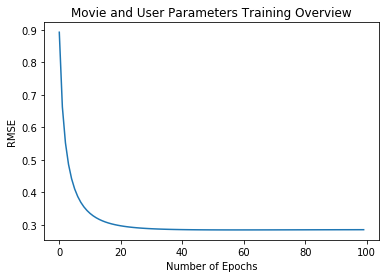

In [375]:
## draw the plot of rmse
## rmse is decreasing
import matplotlib.pyplot as plt
plt.plot(rmse_ls)
plt.ylabel('RMSE')
plt.xlabel('Number of Epochs')
plt.title('Movie and User Parameters Training Overview')

### step 3:make prediction using trained parameters
(also reshape data and make a output table, recommend top 20 rated movie for each user)

In [376]:
final_predict = np.dot(movie_params,user_params)

In [377]:
final_predict_ratings = \
pd.DataFrame(final_predict, index = matrix_ratings.index, columns = matrix_ratings['rating'].columns)

In [378]:
recommended_movie_df = pd.DataFrame(columns = ['user','recommended_movies_list'])

In [379]:
user_list = matrix_ratings['rating'].columns
movie_list = matrix_ratings.index

In [380]:
for i in range(610):
    curr_recommended_movie = {}
    # print(type(np.where(matrix_ratings.iloc[:,i] == 0)[0])
    final_predict_ratings.iloc[np.where(matrix_ratings.iloc[:,i] != 0)[0],i] = 0
    predicted_user_ratings = final_predict_ratings.iloc[:,i]
    # print(predicted_user_ratings.nlargest(20))
    recommended_movie_index = predicted_user_ratings.nlargest(20).index.values
    curr_recommended_movie['user'] = user_list[i]
    curr_recommended_movie['recommended_movies_list'] = recommended_movie_index
    recommended_movie_df = recommended_movie_df.append(curr_recommended_movie,ignore_index = True)

In [381]:
recommended_movie_df

,user,recommended_movies_list
0,1,"[160573, 53453, 165947, 123200, 1987, 30890, 2..."
1,2,"[53453, 160573, 123200, 6912, 30846, 102684, 5..."
2,3,"[6858, 2623, 7988, 160573, 72424, 3834, 141646..."
3,4,"[160573, 53453, 165947, 123200, 1987, 30890, 9..."
4,5,"[53453, 160573, 4251, 6382, 1987, 109971, 1659..."
...,...,...
605,606,"[160573, 53453, 165947, 123200, 1987, 25952, 6..."
606,607,"[160573, 53453, 165947, 123200, 1987, 30890, 2..."
607,608,"[160573, 53453, 165947, 123200, 1987, 30890, 2..."
608,609,"[53453, 160573, 6912, 81535, 123200, 116138, 4..."


In [382]:
splited_recommended_movie_df = pd.DataFrame(recommended_movie_df['recommended_movies_list'].tolist(),\
                                    columns=['movieId1', 'movieId2', 'movieId3','movieId4','movieId5',\
                                            'movieId6', 'movieId7', 'movieId8','movieId9','movieId10',\
                                            'movieId11', 'movieId12', 'movieId13','movieId14','movieId15',\
                                            'movieId16', 'movieId17', 'movieId18','movieId19','movieId20'])

In [383]:
final_recommendation_df = pd.concat([recommended_movie_df, splited_recommended_movie_df], axis=1)

In [384]:
final_recommendation_df.drop('recommended_movies_list',axis = 1,inplace = True)

In [385]:
final_recommendation_df

,user,movieId1,movieId2,movieId3,movieId4,movieId5,movieId6,movieId7,movieId8,movieId9,...,movieId11,movieId12,movieId13,movieId14,movieId15,movieId16,movieId17,movieId18,movieId19,movieId20
0,1,160573,53453,165947,123200,1987,30890,25952,6342,3834,...,117364,6064,131749,86668,311,90384,81535,2632,66335,58975
1,2,53453,160573,123200,6912,30846,102684,58975,49917,165947,...,86668,40412,123310,126577,2632,4251,311,116138,134515,142422
2,3,6858,2623,7988,160573,72424,3834,141646,7282,153408,...,60538,102684,31952,33132,117364,85399,40959,4580,2419,85316
3,4,160573,53453,165947,123200,1987,30890,90384,6342,25952,...,6064,107069,117364,123310,2632,5512,118354,131749,3834,58975
4,5,53453,160573,4251,6382,1987,109971,165947,38583,311,...,7615,2632,7345,3834,123310,123200,189111,67799,6912,40959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,160573,53453,165947,123200,1987,25952,6342,6912,90384,...,3834,6064,131749,2632,58975,311,107069,86668,66335,123310
606,607,160573,53453,165947,123200,1987,30890,25952,3834,117364,...,6912,90384,6064,311,131749,2632,85399,58975,86668,123310
607,608,160573,53453,165947,123200,1987,30890,25952,6912,6342,...,6064,3834,117364,311,86668,2632,58975,131749,123310,107069
608,609,53453,160573,6912,81535,123200,116138,4251,5391,165947,...,89939,64278,123310,49917,107159,3822,25833,31424,132335,476


In [386]:
final_recommendation_df.to_csv('/Users/juli/Desktop/FA21/CS_410/Recommder_System/recommendation_result1.csv')